In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, structure_optimization_lib, \
                    data_utils, cavi_lib, \
                    fast_structure_lib, plotting_utils

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Load data

In [3]:
# data_file = '../../../../fastStructure/test/testdata.npz'
data_file = '../../../../fastStructure/hgdp_data/huang2011_plink_files/' + \
            'phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'

data = np.load(data_file)
g_obs = np.array(data['g_obs'])

g_obs = np.array(data['g_obs'])
g_obs_raw = np.array(data['g_obs_raw'])

# just checking ... 
which_missing = (g_obs_raw == 3)
(g_obs.argmax(-1) == g_obs_raw)[~which_missing].all()
(g_obs[which_missing] == 0).all()

DeviceArray(True, dtype=bool)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Load fastStructure fit

In [22]:
filename = '../../../../fastStructure/fits/huang2011/phased_regions1to26.13'

In [23]:
vb_params_dict, vb_params_paragami = fast_structure_lib.load_fs_to_vb_params(filename)
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2810, 13, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_beta] = NumericArrayPattern (1107, 12, 2) (lb=0.0, ub=inf)


In [24]:
e_ind_admix, e_pop_freq = plotting_utils.get_vb_expectations(vb_params_dict)

### Check against fast-structure saved means

In [25]:
fs_e_ind_admix, _, fs_e_pop_freq, _ = \
    fast_structure_lib.load_fs_means_vars(filename)

In [26]:
np.abs(e_pop_freq - fs_e_pop_freq).max()

DeviceArray(5.08307136e-07, dtype=float64)

In [27]:
np.abs(e_ind_admix - fs_e_ind_admix).max()

DeviceArray(4.99966579e-07, dtype=float64)

In [28]:
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

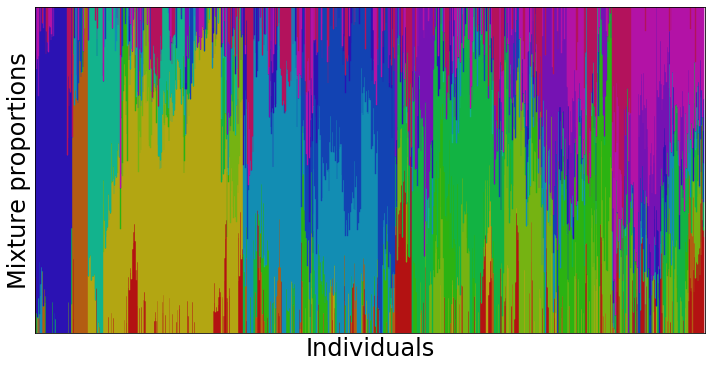

In [30]:
f, axarr = plt.subplots(1, 1, figsize=(12, 6))
plotting_utils.plot_admixture(e_ind_admix[indx], axarr)
axarr.set_xlabel('Individuals', fontsize = 24)
axarr.set_ylabel('Mixture proportions', fontsize = 24);

# Check against my fit

In [14]:
prior_params_dict, prior_params_paragami = structure_model_lib.get_default_prior_params()

In [15]:
vb_opt_dict, vb_opt, _, _  = \
    cavi_lib.run_cavi(g_obs, vb_params_dict,
                vb_params_paragami,
                prior_params_dict, 
                print_every = 20)

Compiling cavi functions ...
CAVI compile time: 3.43sec

 running CAVI ...
iteration [20]; kl:98886.346642; elapsed: 1.1978secs
iteration [40]; kl:98725.432302; elapsed: 1.2536secs
iteration [60]; kl:98646.790622; elapsed: 1.1737secs
iteration [80]; kl:98601.5986; elapsed: 1.167secs
iteration [100]; kl:98574.037794; elapsed: 1.163secs
iteration [120]; kl:98556.722378; elapsed: 1.1639secs
iteration [140]; kl:98545.630701; elapsed: 1.1669secs
iteration [160]; kl:98538.400796; elapsed: 1.1642secs
iteration [180]; kl:98533.59304; elapsed: 1.1663secs
iteration [200]; kl:98530.318735; elapsed: 1.1654secs
iteration [220]; kl:98528.02825; elapsed: 1.1642secs
iteration [240]; kl:98526.38108; elapsed: 1.1697secs
iteration [260]; kl:98525.164838; elapsed: 1.1614secs
iteration [280]; kl:98524.245265; elapsed: 1.1605secs
iteration [300]; kl:98523.535817; elapsed: 1.162secs
iteration [320]; kl:98522.979331; elapsed: 1.1671secs
iteration [340]; kl:98522.537008; elapsed: 1.168secs
iteration [360]; kl:

In [18]:
e_ind_admix_bnp, e_pop_freq_bnp = plotting_utils.get_vb_expectations(vb_params_dict)

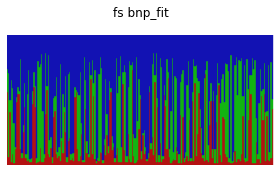

In [20]:
plotting_utils.plot_admixture(e_ind_admix_bnp, 'fs bnp_fit')